# Export Growth Prediction

## Model 1: Multivariate Linear Regression with Categorical Variable

Hypothesis:

$$
(\log Ex - \overline{\log Ex_c}) =
\theta_{0} +
\theta_{1}(g_{GDP} - \overline{{g_{GDP}}_c}) +
\theta_{2}(\log GDP_{capita} - \overline{{\log GDP_{capita}}_c}) +
\theta_{3}(\log Im - \overline{{\log Im}_c}) + \epsilon
$$

where:  
* $Ex$ = export value of Taiwan (in USD)
* $g_{GDP}$ = annual % growth of real GDP of the importing country
* $GDP_{capita}$ = GDP per capita of the importing country (in USD)
* $Im$ = import value of the importing country (in million USD)

and $\overline{\log Ex_c}$, $\overline{{g_{GDP}}_c}$, $\overline{{\log GDP_{capita}}_c}$, $\overline{{\log Im}_c}$ are means over all years of the respective values for country $c$. Also known as the fixed effects model.

#### Preprocessing

In [1]:
import pandas as pd
import numpy as np

def read_lr_data(drop_im_growth=True):
    path = 'C:/Users/2093/Desktop/Data Center/07. 出口預測/2017/data/model.data80_merge_import.xlsx'
    lr_df = pd.read_excel(path)
    names = ['country', 'year', 'gdp_growth', 'ex', 'gdp_capita', 'im_growth', 'im']
    if drop_im_growth:
        lr_df.drop('import_g', axis=1, inplace=True)
        names.remove('im_growth')
    lr_df.columns = names
    lr_df['year'] = pd.to_datetime(lr_df['year'], format='%Y')
    lr_df.set_index('year', inplace=True)
    return lr_df
lr_df = read_lr_data()

def percent_change(data, groupby, col):
    rs = data.groupby(groupby)[col].transform(pd.Series.diff) /\
        data.groupby(groupby)[col].transform(pd.Series.shift) * 100
    return rs
# Compute export growth
lr_df['ex_growth'] = percent_change(lr_df, groupby='country', col='ex')

# Keep only complete cases and remove rows where import value is zero (ITC has no data)
lr_df = lr_df.dropna().query('im != 0')
# Because ITC import values are in thousand USD, multiply by .001
lr_df['im'] = lr_df['im'] * .001
# Take logarithms
lr_df[['ex', 'gdp_capita', 'im']] = lr_df[['ex', 'gdp_capita', 'im']].apply(np.log)

#### Define Group Mean Normalizer Object

In [2]:
import re

class GroupMeanNormalizer(object):
    
    def __init__(self, data, groupby):
        self.groupby = groupby
        self.means = data.groupby(groupby).mean()
        
    def transform(self, data):
        # Applying diff() on int and float will result in NA's, so convert to float
        data = pd.concat([data[[self.groupby]], data.drop(self.groupby, axis=1).astype(float)], axis=1)
        merged = data.merge(self.means, left_on=self.groupby, right_index=True, suffixes=['__x', '__y'])
        # DataFrameGroupBy.diff() seems to base its order of differencing on numerical indices only
        # Alphabetical order of the suffixes is irrelevent
        normalized = pd.concat(
            [merged[self.groupby],
             merged.drop(self.groupby, axis=1).groupby(
                    merged.columns.drop(self.groupby).str.split('__').str[0], axis=1).diff(-1)],
            axis=1)
        normalized = normalized.loc[
            :, normalized.columns.str.contains('__x|{}'.format(self.groupby))].rename(
            columns=lambda x: re.sub('__x', '', x))
        return normalized
    
    def inverse_transform(self, data):
        merged = data.merge(self.means, left_on=self.groupby, right_index=True, suffixes=['__x', '__y'])
        inversed = merged.groupby(merged.columns.str.split('__').str[0], axis=1).sum()
        return inversed

In [3]:
from sklearn.preprocessing import StandardScaler

class StandardScaler_(StandardScaler):
    """Modified StandardScaler that allows categorical input and returns DataFrame."""
        
    def fit(self, X, categorical):
        self.categorical = categorical
        self.index_name = X.index.name
        super(StandardScaler_, self).fit(X.drop(self.categorical, axis=1))
        
    def transform(self, X):
        standardized = super(StandardScaler_, self).transform(X.drop(self.categorical, axis=1))
        standardized = pd.concat([X[[self.categorical]].reset_index(),
                                  pd.DataFrame(standardized)], axis=1).set_index(self.index_name)
        standardized.columns = X.columns
        return standardized
        
    def inverse_transform(self, X):
        inversed = super(StandardScaler_, self).inverse_transform(X.drop(self.categorical, axis=1))
        inversed = pd.concat([X[[self.categorical]].reset_index(),
                              pd.DataFrame(inversed)], axis=1).set_index(self.index_name)
        inversed.columns = X.columns
        return inversed

In [4]:
def compute_g_pred(y_pred, y_actual, g_actual):
    """Compute predicted % growth using predicted log(y), actual log(y), and actual % growth.
    
    Keyword arguments:
    y_pred -- predicted log(y)
    y_actual -- actual log(y)
    g_actual -- actual % growth
    """
    g_pred = 100 * (np.exp(y_pred - (np.log(100)+y_actual) + np.log(g_actual+100)) - 1)
    return g_pred

#### Model Training and Evaluation Framework

In [5]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

class ExportGrowthModel(object):
    
    def __init__(self, data, X, y, model, cv_method, normalize=False, scale=False, n_splits=None,
                 n_train=None, **kwargs):
        
        self.X = X
        self.y = y
        self.model = model
        self.normalize = normalize
        self.scale = scale
        self.kwargs = kwargs
        
        if cv_method == 'most_recent':
            self.test_year = str(data.index.max().year)
            X_train = data.loc[:str(int(self.test_year) - 1), ['country'] + X]
            X_test = data.loc[self.test_year, ['country'] + X]
            if self.model == 'lr_export':
                y_train = data.loc[:str(int(self.test_year) - 1), ['country', y, 'ex_growth']]
                y_test = data.loc[self.test_year, ['country', y, 'ex_growth']]
            else:
                y_train = data.loc[:str(int(self.test_year) - 1), ['country', y]]
                y_test = data.loc[self.test_year, ['country', y]]
            self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
            self._fit()
            self.predict()
            self.evaluate()
            self.summary()
        
        elif cv_method == 'leave_one_out':
            train_errors = []
            test_errors = []
            for yr in pd.Series(data.index.year).unique():
                X_train = data.loc[data.index.year != yr, ['country'] + X]
                X_test = data.loc[str(yr), ['country'] + X]
                if self.model == 'lr_export':
                    y_train = data.loc[data.index.year != yr, ['country', y, 'ex_growth']]
                    y_test = data.loc[str(yr), ['country', y, 'ex_growth']]
                else:
                    y_train = data.loc[data.index.year != yr, ['country', y]]
                    y_test = data.loc[str(yr), ['country', y]]
                self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
                self._fit()
                self.predict()
                self.evaluate()
                train_errors.append(self.train_error)
                test_errors.append(self.test_error)
            self.cv_train_error = pd.Series(train_errors).mean()
            self.cv_test_error = pd.Series(test_errors).mean()
            print('Leave-one-out cv errors:\n- {:5}:{:8.4f}\n- {:5}:{:8.4f}'.format(
                    'Train', self.cv_train_error, 'Test', self.cv_test_error))
                
        elif cv_method == 'skf':
            train_errors = []
            test_errors = []
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)
            for train_index, test_index in skf.split(data, data['country']):
                X_train = data.ix[train_index, ['country'] + X]
                X_test = data.ix[test_index, ['country'] + X]
                if self.model == 'lr_export':
                    y_train = data.ix[train_index, ['country', y, 'ex_growth']]
                    y_test = data.ix[test_index, ['country', y, 'ex_growth']]
                else:
                    y_train = data.ix[train_index, ['country', y]]
                    y_test = data.ix[test_index, ['country', y]]
                self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
                self._fit()
                self.predict()
                self.evaluate()
                train_errors.append(self.train_error)
                test_errors.append(self.test_error)
            self.cv_train_error = pd.Series(train_errors).mean()
            self.cv_test_error = pd.Series(test_errors).mean()
            print('Stratefied {}-fold cv errors:\n- {:5}:{:8.4f}\n- {:5}:{:8.4f}'.format(
                    n_splits, 'Train', self.cv_train_error, 'Test', self.cv_test_error))
            
        elif cv_method == 'sampling':
            data = shuffle(data, random_state=7)
            if self.model == 'lr_export':
                X_train, X_test, y_train, y_test = train_test_split(
                    data[['country'] + X], data[['country', y, 'ex_growth']],
                    test_size=0.3, random_state=7, stratify=data['country'])
                X_train, y_train = X_train.iloc[:n_train, ], y_train.iloc[:n_train, ]
            else:
                X_train, X_test, y_train, y_test = train_test_split(
                    data[['country'] + X], data[['country', y]],
                    test_size=0.4, random_state=3, stratify=data['country'])
                X_train, y_train = X_train.iloc[:n_train, ], y_train.iloc[:n_train, ]
            self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
            self._fit()
            self.predict()
            self.evaluate()

        else:
            raise ValueError('Invalid cv_method. Must be one of "most_recent", "leave_one_out", \
            "skf", or "sampling"')
            
    def _fit(self):
        
        if self.normalize:
            self.X_normalizer = GroupMeanNormalizer(self.X_train, groupby='country')
            self.y_normalizer = GroupMeanNormalizer(self.y_train, groupby='country')
            self.X_train = self.X_normalizer.transform(self.X_train)
            self.y_train = self.y_normalizer.transform(self.y_train)
        elif self.scale:
            self.X_scaler = StandardScaler_()
            self.y_scaler = StandardScaler_()
            self.X_scaler.fit(self.X_train, categorical='country')
            self.y_scaler.fit(self.y_train, categorical='country')
            self.X_train = self.X_scaler.transform(self.X_train)
            self.y_train = self.y_scaler.transform(self.y_train)

        models = dict(
            lr_export=LinearRegression(),
            lr_growth=LinearRegression(),
            svr=SVR(),
            rf=RandomForestRegressor(),
            ada=AdaBoostRegressor(),
            gbrt=GradientBoostingRegressor()
        )
        self.regr = models[self.model]
        self.regr.set_params(**self.kwargs)
        if self.model == 'lr_export':
            self.regr.fit(self.X_train.drop('country', axis=1),
                          self.y_train.drop(['country', 'ex_growth'], axis=1).values.ravel())
        else:
            self.regr.fit(self.X_train.drop('country', axis=1),
                          self.y_train.drop('country', axis=1).values.ravel())
        if self.model == 'lr_export' or self.model == 'lr_growth':
            self.coef_ = self.regr.coef_

        if self.normalize:
            self.y_train = self.y_normalizer.inverse_transform(self.y_train)
        elif self.scale:
            self.y_train = self.y_scaler.inverse_transform(self.y_train)
    
    def predict(self):
        
        if self.normalize:
            self.X_test = self.X_normalizer.transform(self.X_test)
        elif self.scale:
            self.X_test = self.X_scaler.transform(self.X_test)
        
        def pred(X_data, y_data):
            y_pred = pd.DataFrame(
                {'country': X_data['country'],
                 self.y: self.regr.predict(X_data.drop('country', axis=1)).reshape((len(X_data),))})
            if self.normalize:
                y_pred = self.y_normalizer.inverse_transform(y_pred)
            elif self.scale:
                y_pred = self.y_scaler.inverse_transform(y_pred)
            y_data[self.y+'_pred'] = y_pred[self.y].tolist()
            if self.model == 'lr_export':
                y_data['ex_growth_pred'] = compute_g_pred(
                    y_data[self.y+'_pred'], y_data[self.y], y_data['ex_growth'])
            return y_data
        
        self.y_train = pred(self.X_train, self.y_train)
        self.y_test = pred(self.X_test, self.y_test)
        self.result = self.y_test
    
    def evaluate(self):
        
        def rmse(actual, pred):
            return np.sqrt(mean_squared_error(actual, pred))
        
        if self.model == 'lr_export':
            self.train_error = rmse(self.y_train['ex_growth'], self.y_train['ex_growth_pred'])
            self.test_error = rmse(self.y_test['ex_growth'], self.y_test['ex_growth_pred'])
        else:
            self.train_error = rmse(self.y_train[self.y], self.y_train[self.y+'_pred'])
            self.test_error = rmse(self.y_test[self.y], self.y_test[self.y+'_pred'])       
    
    def summary(self):

        print('- Train: {:,} data points of {} countries from {} throuth {}.\n\
- Test: {:,} data points of {} countries from {} throuth {}.\n'.format(
                len(self.X_train), self.X_train['country'].nunique(),
                self.X_train.index.min().year, self.X_train.index.max().year,
                len(self.X_test), self.X_test['country'].nunique(),
                self.X_test.index.min().year, self.X_test.index.max().year))

        print('Coefficients:\n')
        for x in zip(self.X, self.coef_):
            print('{:10}: {:6.4f}'.format(*x))
        
        order = [self.y, self.y+'_pred']
        if self.model == 'lr_export':
            order += ['ex_growth', 'ex_growth_pred']
        print('\nSummary of results:\n' +
              tabulate(self.result[order].describe(), headers='keys', tablefmt='psql') + '\n')
        print('{:14}:{:8.4f}\n{:14}:{:8.4f}'.format('Training error', self.train_error,
                                                    'Test error', self.test_error))

In [6]:
model1 = ExportGrowthModel(data=lr_df, X=['gdp_growth', 'gdp_capita', 'im'], y='ex',
                           model='lr_export', normalize=True, cv_method='most_recent')

- Train: 1,007 data points of 80 countries from 2001 throuth 2013.
- Test: 80 data points of 80 countries from 2014 throuth 2014.

Coefficients:

gdp_growth: 0.0149
gdp_capita: 0.4575
im        : 0.5429

Summary of results:
+-------+----------+-----------+-------------+------------------+
|       |       ex |   ex_pred |   ex_growth |   ex_growth_pred |
|-------+----------+-----------+-------------+------------------|
| count | 80       |  80       |    80       |         80       |
| mean  | 20.2867  |  20.317   |    -2.51924 |          6.5175  |
| std   |  1.69717 |   1.77501 |    19.7555  |         35.2405  |
| min   | 17.4054  |  16.6646  |   -70.5364  |        -94.9824  |
| 25%   | 18.846   |  18.9051  |   -12.3459  |         -6.41581 |
| 50%   | 19.8687  |  20.068   |     1.82052 |          9.96134 |
| 75%   | 21.2655  |  21.3307  |     8.80674 |         24.1087  |
| max   | 25.0705  |  25.2897  |    40.5683  |        140.309   |
+-------+----------+-----------+-------------+----

#### Leave-1-Year-Out CV and Stratefied K-Fold CV

In [7]:
ExportGrowthModel(data=lr_df, X=['gdp_growth', 'gdp_capita', 'im'], y='ex',
                  model='lr_export', normalize=True, cv_method='leave_one_out')
ExportGrowthModel(data=lr_df, X=['gdp_growth', 'gdp_capita', 'im'], y='ex',
                  model='lr_export', normalize=True, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 71.3731
- Test : 56.9389
Stratefied 5-fold cv errors:
- Train: 69.4564
- Test : 66.8216


#### Plotting Results

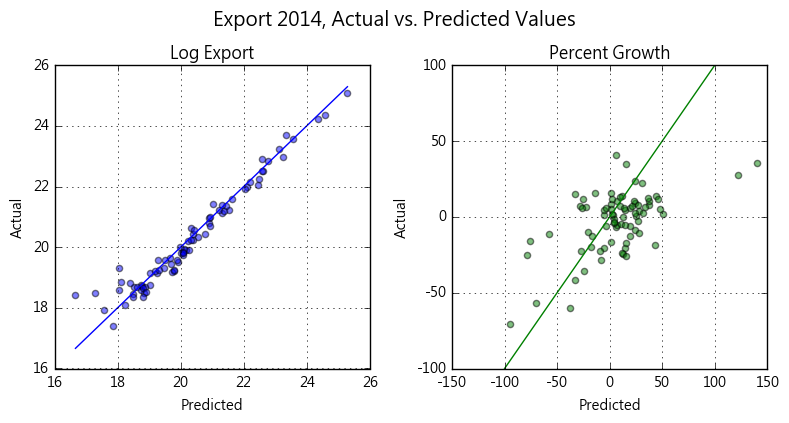

In [8]:
import matplotlib.pyplot as plt

def plot_model_comparison(
    left_data, right_data, left_x, left_y, right_x, right_y, title, left_title, right_title,
    left_refline=None, right_refline=None, left_scale=None, right_scale=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plt.suptitle(title, y=1.05, size=14)
    
    def plot_prediction(data, x, y, ax, title, c='b', refline=None, scale=None):
        data.plot(ax=axes[ax], x=x, y=y, kind='scatter', alpha=0.5, c=c, title=title)
        if refline is None:
            x_min, x_max = data[x].min(), data[x].max()
            axes[ax].plot([x_min, x_max], [x_min, x_max], c)
        else:
            axes[ax].plot(refline, refline, c)
        if scale is not None:
            axes[ax].axis(scale)
        axes[ax].set_xlabel('Predicted')
        axes[ax].set_ylabel('Actual')
        axes[ax].grid()
        return
    
    plot_prediction(data=left_data, x=left_x, y=left_y, ax=0, title=left_title,
                   refline=left_refline, scale=left_scale)
    plot_prediction(data=right_data, x=right_x, y=right_y, ax=1, title=right_title,
                    c='g', refline=right_refline, scale=right_scale)
    plt.tight_layout()
    plt.show()
    return

rs1 = model1.result
plot_model_comparison(
    left_data=rs1, right_data=rs1, left_x='ex_pred', left_y='ex',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Export {}, Actual vs. Predicted Values'.format(model1.test_year),
    left_title='Log Export', right_title='Percent Growth', right_refline=[-100, 100],
    right_scale=[-150, 150, -100, 100])

---

## Model 2: Multivariate Regression on All Percent Changes

(a) Using mean normalized % changes  
(b) Using % changes

#### Preprocessing

In [9]:
lr_df = read_lr_data(drop_im_growth=False)
# Compute growth in export and GDP per capita
lr_df['ex_growth'] = percent_change(lr_df, groupby='country', col='ex')
lr_df['capita_growth'] = percent_change(lr_df, groupby='country', col='gdp_capita')
# Keep only complete cases
lr_df = lr_df[['country', 'ex_growth', 'gdp_growth', 'capita_growth', 'im_growth']].dropna()

#### EDA

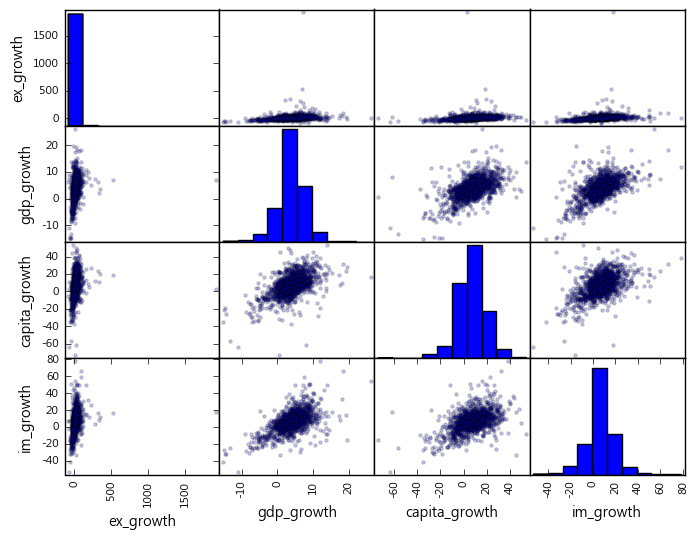

Correlation coefficients:

                ex_growth  gdp_growth  capita_growth  im_growth
ex_growth       1.000000    0.206633       0.192484   0.233350
gdp_growth      0.206633    1.000000       0.552122   0.591538
capita_growth   0.192484    0.552122       1.000000   0.502015
im_growth       0.233350    0.591538       0.502015   1.000000


In [10]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(lr_df, alpha=0.2, figsize=(8, 6))
plt.show()
print('Correlation coefficients:\n\n', lr_df.corr())

Clearly there are a number of extreme values. Try removing them and see if things get better.

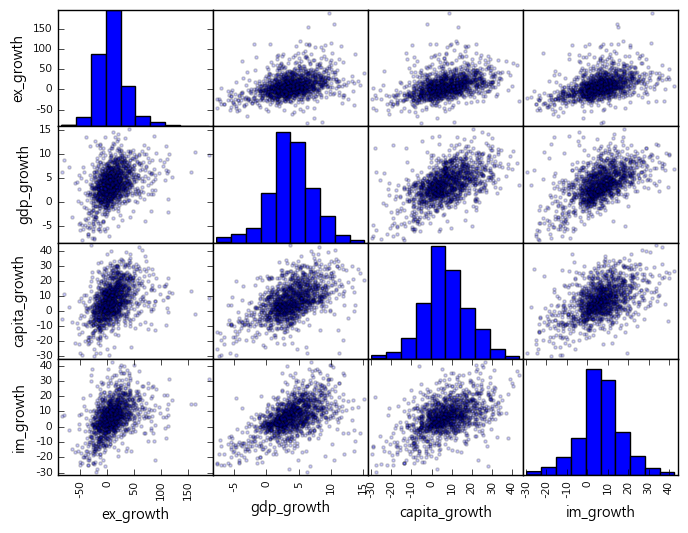

Correlation coefficients:

                ex_growth  gdp_growth  capita_growth  im_growth
ex_growth       1.000000    0.368422       0.385075   0.417567
gdp_growth      0.368422    1.000000       0.532011   0.544541
capita_growth   0.385075    0.532011       1.000000   0.489091
im_growth       0.417567    0.544541       0.489091   1.000000


In [11]:
from functools import reduce

idx = (np.abs((lr_df.drop('country', axis=1) - lr_df.drop('country', axis=1).mean()) /\
              lr_df.drop('country', axis=1).std()) <= 3).apply(
    lambda x: reduce(np.logical_and, x), axis=1)
outlier_rm = lr_df[idx]

scatter_matrix(outlier_rm, alpha=0.2, figsize=(8, 6))
plt.show()
print('Correlation coefficients:\n\n', outlier_rm.corr())

Now it looks much better.

### (a) Using Mean Normalized % Changes

- Train: 1,230 data points of 80 countries from 1998 throuth 2013.
- Test: 80 data points of 80 countries from 2014 throuth 2014.

Coefficients:

gdp_growth: 1.3296
capita_growth: 0.3595
im_growth : 0.6077

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    80       |        80        |
| mean  |    -2.51924 |         5.22278  |
| std   |    19.7555  |         9.96874  |
| min   |   -70.5364  |       -21.5347   |
| 25%   |   -12.3459  |        -0.589379 |
| 50%   |     1.82052 |         5.38345  |
| 75%   |     8.80674 |        12.0363   |
| max   |    40.5683  |        27.5887   |
+-------+-------------+------------------+

Training error: 23.8076
Test error    : 21.5827


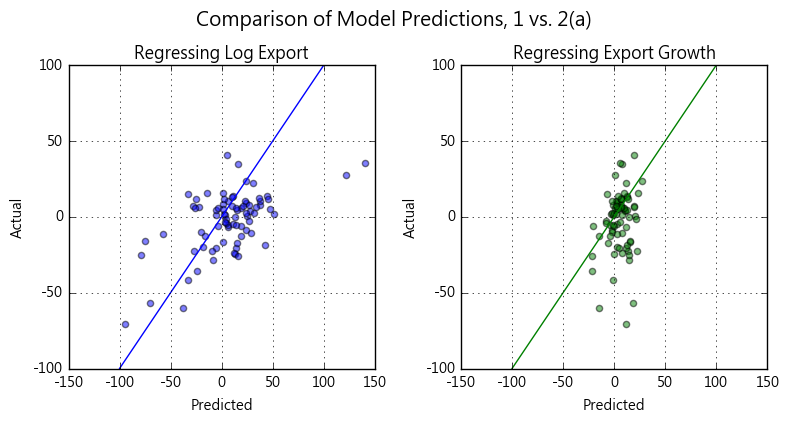

In [12]:
model2a = ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'],
                            y='ex_growth', model='lr_growth', normalize=True, cv_method='most_recent')

rs2a = model2a.result
plot_model_comparison(
    left_data=rs1, right_data=rs2a, left_x='ex_growth_pred', left_y='ex_growth',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Comparison of Model Predictions, 1 vs. 2(a)',
    left_title='Regressing Log Export', right_title='Regressing Export Growth',
    left_refline=[-100, 100], right_refline=[-100, 100],
    left_scale=[-150, 150, -100, 100], right_scale=[-150, 150, -100, 100])

In [13]:
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=True, cv_method='leave_one_out')
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=True, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 23.5746
- Test : 24.9230
Stratefied 5-fold cv errors:
- Train: 23.4448
- Test : 25.1798


### (b) Using % Changes

- Train: 1,230 data points of 80 countries from 1998 throuth 2013.
- Test: 80 data points of 80 countries from 2014 throuth 2014.

Coefficients:

gdp_growth: 1.1691
capita_growth: 0.4453
im_growth : 0.6311

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    80       |        80        |
| mean  |    -2.51924 |         4.7159   |
| std   |    19.7555  |         9.43238  |
| min   |   -70.5364  |       -34.2901   |
| 25%   |   -12.3459  |         0.579199 |
| 50%   |     1.82052 |         5.39069  |
| 75%   |     8.80674 |         9.38532  |
| max   |    40.5683  |        30.0854   |
+-------+-------------+------------------+

Training error: 24.6286
Test error    : 19.2104


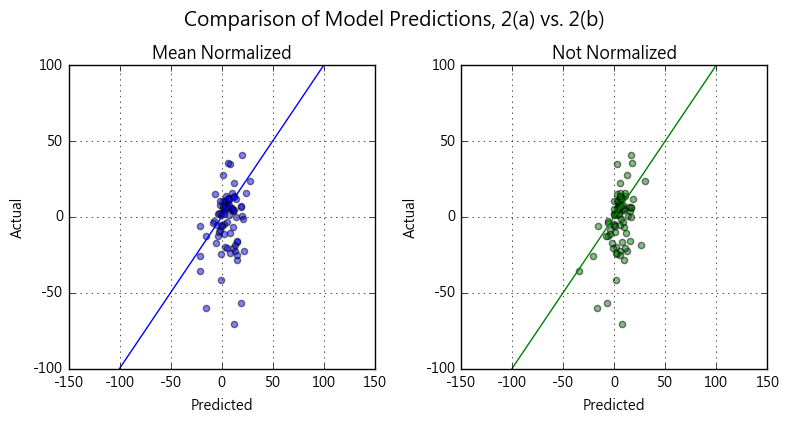

In [14]:
model2b = ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'],
                            y='ex_growth', model='lr_growth', normalize=False, cv_method='most_recent')

rs2b = model2b.result
plot_model_comparison(
    left_data=rs2a, right_data=rs2b, left_x='ex_growth_pred', left_y='ex_growth',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Comparison of Model Predictions, 2(a) vs. 2(b)',
    left_title='Mean Normalized', right_title='Not Normalized',
    left_refline=[-100, 100], right_refline=[-100, 100],
    left_scale=[-150, 150, -100, 100], right_scale=[-150, 150, -100, 100])

In [15]:
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=False, cv_method='leave_one_out')
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=False, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 24.3098
- Test : 24.0644
Stratefied 5-fold cv errors:
- Train: 24.3153
- Test : 24.3608


#### Learning Curves: Are More Data Likely to Help?

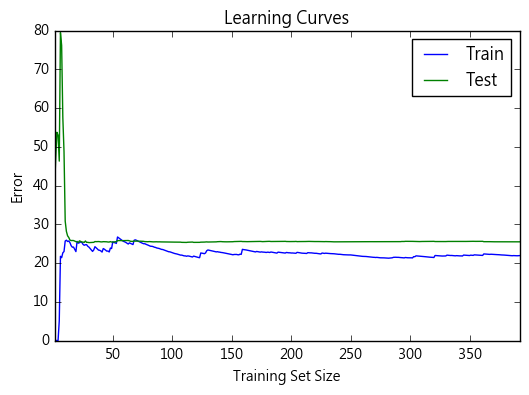

In [16]:
def learning_curves(model, **kwargs):
    n_trains = range(1, round(len(outlier_rm) * .3))
    train_errors = []
    test_errors = []
    for n_train in n_trains:
        mdl = ExportGrowthModel(
            data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
            model=model, normalize=False, cv_method='sampling', n_train=n_train, **kwargs)
        train_errors.append(mdl.train_error)
        test_errors.append(mdl.test_error)
        
    curve_dt = pd.DataFrame(dict(n_train=n_trains, train_error=train_errors, test_error=test_errors))
    curve_dt.plot(x='n_train', y=['train_error', 'test_error'])
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend(['Train', 'Test'])
    plt.show()
    return
learning_curves(model='lr_growth')

Not surprisingly, model 2(b) has high bias. Thus a test error of around 24 percentage point is the best we can expect from it.

#### Error Analysis

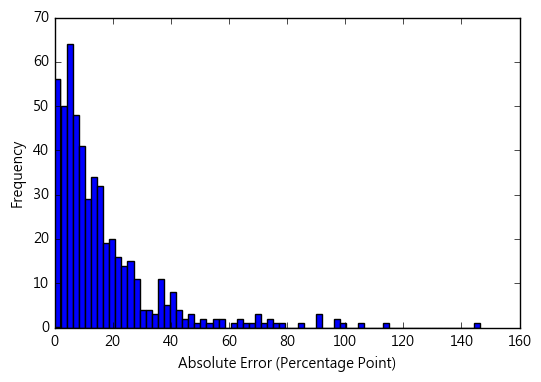

In [17]:
model = ExportGrowthModel(
    data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
    model='lr_growth', normalize=False, cv_method='sampling', n_train=round(len(outlier_rm) * .7))
model_rs = model.y_test
model_rs['ae'] = (model_rs['ex_growth'] - model_rs['ex_growth_pred']).abs()

model_rs['ae'].plot(kind='hist', bins=70)
plt.xlabel('Absolute Error (Percentage Point)')
plt.show()

In [18]:
mae = model_rs[['country', 'ae']].groupby('country').mean().sort_values('ae', ascending=False)
faroff = mae.head(10)
closest = mae.tail(10).iloc[::-1, :]
print('Countries with the most far-off predicted values on average:\n\n{:2}  {:23}  {:5}'.format(
        '', 'Country', 'AE'))
for lab, row in faroff.iterrows():
    print('{:2}. {:23}: {:5.2f}'.format(faroff.index.get_loc(lab)+1, lab, row['ae']))
print('\nCountries with the closest predicted values on average:\n\n{:2}  {:23}  {:5}'.format(
        '', 'Country', 'AE'))
for lab, row in closest.iterrows():
    print('{:2}. {:23}: {:5.2f}'.format(closest.index.get_loc(lab)+1, lab, row['ae']))

Countries with the most far-off predicted values on average:

    Country                  AE   
 1. Mozambique             : 61.60
 2. Estonia                : 49.82
 3. Panama                 : 47.74
 4. Kenya                  : 43.26
 5. Ghana                  : 39.89
 6. Papua New Guinea       : 34.83
 7. Hungary                : 34.40
 8. Uruguay                : 32.83
 9. Bulgaria               : 31.38
10. Czech Rep.             : 30.60

Countries with the closest predicted values on average:

    Country                  AE   
 1. Canada                 :  3.18
 2. Japan                  :  4.34
 3. Saudi Arabia           :  5.28
 4. Malaysia               :  5.38
 5. Indonesia              :  5.42
 6. Germany                :  5.89
 7. Israel                 :  6.91
 8. Australia              :  7.10
 9. Spain                  :  7.61
10. Thailand               :  7.65


In [19]:
from scipy.stats import zscore
from scipy.stats import f_oneway

mae['group'] = pd.cut(zscore(mae.pow(1/4)).reshape((len(mae),)),
                      bins=range(-3, 4), labels=range(1, 7), include_lowest=True)
anova_dt = read_lr_data().groupby('country').mean().merge(mae, left_index=True, right_index=True)

def oneway_anova(variable):
    gps = []
    for g in range(6):
        gps.append(anova_dt.loc[anova_dt['group'] == g+1, variable].values)
    return f_oneway(*gps)

variables = sorted(anova_dt.columns.drop(['ae', 'group']))
print('{:10}  {:11} {:7}'.format('Variable', 'F-statistic', 'p-value'))
for x in zip(variables, map(oneway_anova, variables)):
    print('{:10}: {:11.4f} {:7.4f}'.format(x[0], x[1][0], x[1][1]))

Variable    F-statistic p-value
ex        :      1.2602  0.2902
gdp_capita:      1.5176  0.1947
gdp_growth:      1.2787  0.2822
im        :      2.3532  0.0487


The amount of prediction errors seems to correlate with total import of and Taiwan's export to a country. To verify this, we compare those countries with the largest prediction errors with those with the smallest errors.

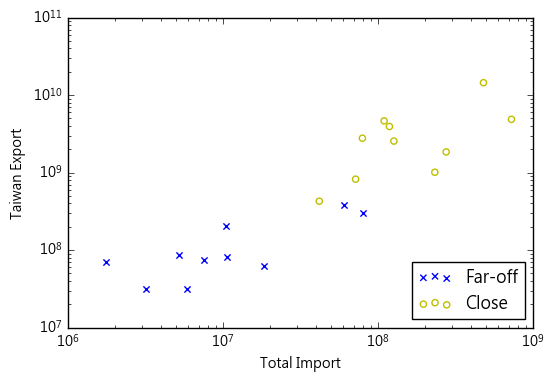

In [20]:
anova_dt_faroff = anova_dt.loc[anova_dt.index.isin(faroff.index), ['ex', 'im']]
anova_dt_closest = anova_dt.loc[anova_dt.index.isin(closest.index), ['ex', 'im']]
plt.scatter(anova_dt_faroff['im'], anova_dt_faroff['ex'], c='b', marker='x')
plt.scatter(anova_dt_closest['im'], anova_dt_closest['ex'], facecolors='none', edgecolors='y')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Import')
plt.ylabel('Taiwan Export')
plt.legend(['Far-off', 'Close'], loc='lower right')
plt.show()

The decision boundary is somewhat clean-cut. So our guess was indeed correct: the less Taiwan exports to a country and the less the country itself imports on the whole, the more far-off the predicted values are.

## Model 3: SVR

#### Cross Validation Curve

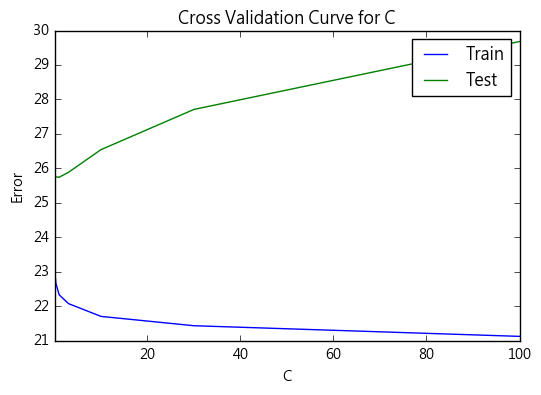

Optimal C = 1.0


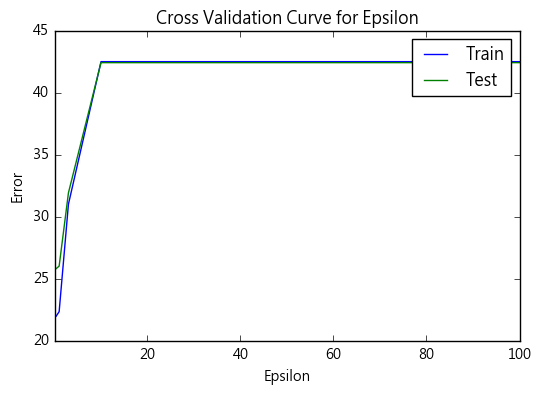

Optimal epsilon = 0.3


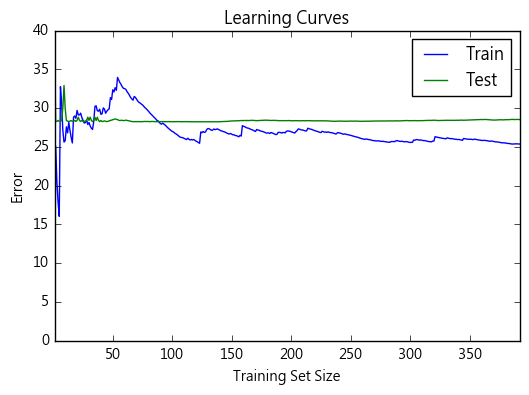

In [21]:
def cv_curve(model, **params):
    """Plot cross validation curve.
    
    Keyword arguments:
    ------------------
    **params -- model parameters as key/value pairs. Exactly one of the parameters should be provided
                with a list of values for comparing cv errors.
    """
    cv_param = [{k:v} for k, v in params.items() if type(v) == list][0]
    others = {k:v for k, v in params.items() if type(v) != list}
    cv_param_pairs = [[{key:val} for val in vals] for key, vals in cv_param.items()][0]
    train_errors = []
    test_errors = []
    for pair in cv_param_pairs:
        mdl = ExportGrowthModel(
            data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
            model=model, **pair, **others, scale=True, cv_method='sampling',
            n_train=round(len(outlier_rm) * .5))
        train_errors.append(mdl.train_error)
        test_errors.append(mdl.test_error)
    param = list(cv_param.keys())[0]
    curve_dt = pd.DataFrame(
        dict(param=list(cv_param.values())[0], train_error=train_errors, test_error=test_errors))
    curve_dt.plot(x='param', y=['train_error', 'test_error'])
    plt.title('Cross Validation Curve for {}'.format(param.title()))
    plt.xlabel('{}'.format(param.title()))
    plt.ylabel('Error')
    plt.legend(['Train', 'Test'])
    plt.show()
    optimal = curve_dt.loc[curve_dt['test_error'] == curve_dt['test_error'].min(), 'param'].values[0]
    print('Optimal {} = {}'.format(param, optimal))
    return optimal

optimal_C = cv_curve(model='svr', kernel='rbf', C=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])
optimal_epsilon = cv_curve(model='svr', kernel='rbf', C=3, epsilon=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])
learning_curves(model='svr', kernel='rbf', C=optimal_C, epsilon=optimal_epsilon)

In [22]:
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='svr', kernel='rbf', C=optimal_C, epsilon=optimal_epsilon, scale=True,
                  cv_method='leave_one_out')
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='svr', kernel='rbf', C=optimal_C, epsilon=optimal_epsilon, scale=True,
                  cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 23.6458
- Test : 24.1895
Stratefied 5-fold cv errors:
- Train: 23.6113
- Test : 24.3536


## Model 4: Random Forests

## Model 5: AdaBoost

## Model 6: Gradient Boosting

## Model 7: SARIMA

#### Scrape Monthly Export Data

In [1]:
%% time

import datetime
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from io import StringIO
import pandas as pd
from functools import reduce

def get_mof_ts():
    
    current_year = datetime.datetime.now().year - 1911
    url = 'https://portal.sw.nat.gov.tw/APGA/GA06_csv'
    # Suppress InsecureRequestWarning
    requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

    def get_data(year):
        payload = {'searchInfo.StartYear': str(year),
                   'searchInfo.EndYear': '',
                   'searchInfo.StartMonth': '1',
                   'searchInfo.EndMonth': '12',
                   'searchInfo.TypeTime': '0',
                   'searchInfo.Type': 'MoneyUSD',
                   'searchInfo.CountryName': '全部國家合計,千里達,土耳其,土庫曼,大溪地,不丹,中非,中國大陸,丹麥,厄瓜多,厄利垂亞,巴布亞紐幾內亞,巴西,巴貝多,巴拉圭,巴林,巴哈馬,巴拿馬,巴勒斯坦,巴基斯坦,日本,比利時,牙買加,以色列,加拿大,加彭,北韓,卡達,古巴,史瓦濟蘭,尼日,尼加拉瓜,尼泊爾,布吉納法索,未列名法屬中美洲領域,未列名美屬中美洲領域,未列名美屬太平洋領域,未列名英屬中美洲領域,瓜地馬拉,甘比亞,白俄羅斯,立陶宛,伊拉克,伊朗,冰島,列支敦斯登,匈牙利,印尼,印度,吉布地,吉里巴斯,吉爾吉斯,吐瓦魯,多米尼克,多明尼加,多哥,安地卡,安圭拉,安哥拉,安道爾,衣索比亞,西班牙,西撒哈拉,克羅埃西亞,利比亞,宏都拉斯,希臘,沙烏地阿拉伯,汶萊,貝里斯,貝南,赤道幾內亞,辛巴威,亞美尼亞,亞塞拜然,其他大洋洲國家,其他中東及近東國家,其他中美洲國家,其他北美洲國家,其他亞洲國家,其他非洲國家,其他南美洲國家,其他國家,其他歐洲國家,坦尚尼亞,奈及利亞,委內瑞拉,孟加拉,尚比亞,帛琉,拉脫維亞,東加,波士尼亞赫塞哥維納,波札那,波多黎各,波蘭,法國,法屬圭亞那,肯亞,芬蘭,阿拉伯聯合大公國,阿根廷,阿曼,阿富汗,阿爾及利亞,阿爾巴尼亞,保加利亞,俄羅斯,南非,南韓,南蘇丹,哈薩克,柬埔寨,查德,玻利維亞,科威特,突尼西亞,約旦,美國,美屬薩摩亞,茅利塔尼亞伊斯蘭共和國,英國,迦納,香港,剛果,剛果民主共和國,哥倫比亞,哥斯大黎加,埃及,挪威,格陵蘭,格瑞那達,泰國,海地,烏干達,烏克蘭,烏拉圭,烏茲別克,琉球,秘魯,索馬利亞,索羅門群島,紐西蘭,納米比亞,納維斯,馬利,馬來西亞,馬其頓,馬拉威,馬約特,馬紹爾群島共和國,馬達加斯加,馬爾他,馬爾地夫,捷克,捷克,教廷,敘利亞,莫三比克,荷蘭,喀麥隆,喬治亞,幾內亞,幾內亞比索,斐濟,斯里蘭卡,斯洛伐克,斯洛維尼亞,智利,菲律賓,象牙海岸,越南,塞內加爾,塞席爾,塞爾維亞,塞爾維亞與蒙特內哥羅,塔吉克,奧地利,愛沙尼亞,愛爾蘭,新加坡,新克里多尼亞,獅子山,瑞士,瑞典,萬那杜,義大利,聖文森,聖多美普林西比,聖克里斯多福,聖馬利諾,聖露西亞,葉門,葛摩聯盟,葡萄牙,維德角,蒙古,蒙特內哥羅共和國,蒙瑟拉特,蒲隆地,蓋亞那,寮國,德國,摩洛哥,摩納哥,摩爾多瓦,模里西斯,緬甸,黎巴嫩,墨西哥,澳大利亞,澳門,盧安達,盧森堡,諾魯,賴比瑞亞,賴索托,賽普勒斯,薩伊,薩爾瓦多,薩摩亞,羅馬尼亞,關島,蘇丹,蘇利南,蘇聯',
                   'noData': 'false'}
        resp = requests.post(url, data=payload, verify=False)
        skiprows = None
        # For data after 2016, need to remove header "註：105年起按一般貿易制度編製。"
        if year >= 105:
            skiprows = 1
        # Get data in bytes, decode, and convert to dataframe
        df = pd.read_csv(StringIO(resp.content.decode(encoding='big5')), skiprows=skiprows)[
            ['日期', '國家', '出口總值']]
        return df

    df_map = map(lambda x: get_data(x), range(92, current_year + 1))
    df = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), df_map)

    # Parse into year and month
    df[['year', 'month']] = df['日期'].str.extract('(\d+)年(\d+)月', expand=False)
    # Create DatetimeIndex
    df.index = pd.to_datetime((df['year'].astype(int) + 1911).astype(str) + '-' + df['month'],
                              format='%Y-%m')
    df.index.name = 'date'
    # Keep only useful columns
    df = df[['國家', '出口總值']]
    df.columns = ['country', 'export']
    # Make wide dataframe
    df = pd.pivot_table(df, index=df.index, columns='country', values='export', fill_value=0)

    # Sum of newsouth eighteen and ten
    eighteen = ['不丹', '印尼', '印度', '孟加拉', '寮國', '尼泊爾', '巴基斯坦', '斯里蘭卡', '新加坡',
                '柬埔寨', '汶萊', '泰國', '澳大利亞', '紐西蘭', '緬甸', '菲律賓', '越南', '馬來西亞']
    ten = ['印尼', '寮國', '新加坡', '柬埔寨', '汶萊', '泰國', '緬甸', '菲律賓', '越南', '馬來西亞']
    df['十八國'] = df.loc[:, eighteen].sum(axis=1)
    df['十國'] = df.loc[:, ten].sum(axis=1)

    return df

ts = get_mof_ts()

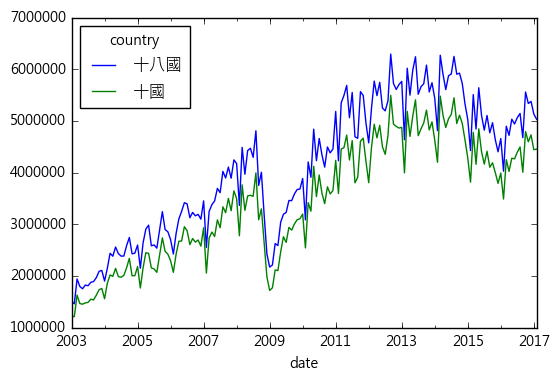

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
ts[['十八國', '十國']].plot()
plt.show()

## Model 8: Neural Network

## Model 9: Randomized Feature Selection

## Ensemble 1: Averaging Ensemble

## Ensemble 2: Standard Linear Regression Stacking

$$b(x) = \sum_i w_i g_i(x),\forall x$$

## Ensemble 3: Feature-Weighted Linear Stacking (FWLS)

$$b(x) = \sum_{i, j}\ v_{ij}\ f_j(x)\ g_i(x), \forall x$$

where $f_j$ are meta-feature functions.